# Problem Statement

The large company who is into beverages business in Australia. They sell their products through various super-markets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed forecast of each of products at item level every week in weekly buckets.

# Objective

1. Build at least 4-5 multivariable forecasting model which included ML or Deep Learning based Model in PySpark leveraging parallel computing techniques.

2. Demonstrate best in class forecast accuracy (Forecast Accuracy = 1 - Wt. MAPE where Wt. MAPE = sum(Error)/sum(Actual).

3. Write a code in such a way you run the model in least time.

4. Demonstrate explainability in the form of contribution of each variables

5. Leveage Feature Engineering concepts to derive more variables to gain accuracy improvement


# NOTICE!

This week (Week 8), I did only **some** of the data preprocessing tasks and **some of them** are explained and already executed, Week 9 will contain part 1 & 2 merged as the full data preprocessing finished.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/papitaAlgodonCplusplus/LISUM24/main/Week%207/Datatset/forecasting_case_study.csv')

# Dataset Raw Visualization

In [98]:
df

,Product,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,year,month,day
0,SKU1,27750,0.000000,0,0,0,0.879592,0,0,0,0,2017,2,5
1,SKU1,29023,0.000000,1,0,1,0.879592,0,1,0,0,2017,2,12
2,SKU1,45630,0.204819,0,0,0,0.879592,0,0,0,0,2017,2,19
3,SKU1,26789,0.000000,1,0,1,0.879592,0,0,0,0,2017,2,26
4,SKU1,41999,0.204819,0,0,0,0.879592,0,0,0,0,2017,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,SKU6,96619,0.650602,0,1,0,0.646187,1,0,0,0,2020,10,18
1214,SKU6,115798,0.626506,0,1,0,0.620562,1,0,0,0,2020,10,25
1215,SKU6,152186,0.650602,1,0,1,0.650201,1,0,0,0,2020,11,1
1216,SKU6,26445,0.530120,1,0,1,0.695894,1,0,0,0,2020,11,8


# Features


* **Product:** X Product that the company offers to their clients

* **Date:** *Month - Day - Year* where row X transactions ocurred

* **Sales:** Number of products X sold that day

* **Price Discount (%):** Discount applied to the product X that day

* **In-Store Promo:** Wheter there was promotion of that product indoors or not

* **Catalogue Promo:** Wheter there was promotion of that product in the catalogue or not

* **Store End Promo:** Wheter there was promotion of that product outdoors or not

* **Google_Mobility:** Google Mobility, also known as Google COVID-19 Community Mobility Reports, is a data initiative launched by Google to provide insights into how people's movements and activities have changed in response to the COVID-19 pandemic, this as a feature column with ranges [-inf, inf] means wheter X product sales during Y date were supossed to change or not, and by how much.

* **Covid_Flag:** A binary column that only activates when google mobility predicts changes on sales of X product during Y date.

* **V_DAY:** Wheter that day was Valentine's day for the company or not

* **Easter:** Wheter that day was Easter for the company or not

* **Christmas:** Wheter that day was Christmas for the company or not

# Data types

**Categorical Data:**
- Product: X Product that the company offers to their clients

**Continuous Numerical Data:**
- Date: Month - Day - Year where row X transactions occurred (If changed to another analogous format)
- Sales: Number of products X sold that day
- Price Discount (%): Discount applied to product X that day
- Google_Mobility: Google Mobility index indicating the change in sales due to the COVID-19 pandemic (ranges [-inf, inf])

**Binary Data:**
- In-Store Promo: Whether there was an indoor promotion of that product or not
- Catalogue Promo: Whether there was a promotion of that product in the catalogue or not
- Store End Promo: Whether there was an outdoor promotion of that product or not
- Covid_Flag: A binary column that activates when Google Mobility predicts changes in sales of X product during Y date
- V_DAY: Whether that day was Valentine's day for the company or not
- Easter: Whether that day was Easter for the company or not
- Christmas: Whether that day was Christmas for the company or not

# Data preprocessing

## NA values

In [84]:
na_counts = df.isna().sum()

for column, na_count in na_counts.items():
    print(f"{column}: {na_count}")

Product: 0
date: 0
Sales: 0
Price Discount (%): 0
In-Store Promo: 0
Catalogue Promo: 0
Store End Promo: 0
Google_Mobility: 0
Covid_Flag: 0
V_DAY: 0
EASTER: 0
CHRISTMAS: 0


## Outliers

In [85]:
def plot_data(df, column, sort=False, x=None):
  if sort:
    sorted_df = df.sort_values(by=column)
    plt.plot(sorted_df[column], sorted_df[x])
    plt.title('Sorted: '+ column + ' by ' + x)
    plt.xlabel(x)
    plt.ylabel(column)
    plt.show()

  else:
    # Plotting numerical column
    plt.figure(figsize=(10, 6))
    if x != None:
      plt.scatter(df[column], df[x])
      plt.xlabel(column)
      plt.ylabel(x)
      plt.title('Scatter Plot')
      plt.show()
    else:
      plt.plot(df[column])
      plt.title(column)
      plt.show()

def delete_noise(df, column, reduction_method='IQR', error_margin=1.5, plot_noise=True, threshold=4, renew=True):
  if reduction_method == 'IQR':
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - error_margin * IQR
    upper_bound = Q3 + error_margin * IQR

    noisy_indices = (df[column] < lower_bound) | (df[column] > upper_bound)

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df.drop(df.index[noisy_indices]).copy()

  if reduction_method == 'Statistical':
    mean = df[column].mean()
    std_dev = df[column].std()

    noise_threshold = mean + threshold * std_dev
    noisy_indices = (df[column] - mean).abs() > threshold * std_dev

    if plot_noise:
      df['Is_Noisy'] = noisy_indices

      plt.figure(figsize=(10, 6))
      plt.scatter(df.index, df[column], c=df['Is_Noisy'], cmap='coolwarm', marker='o')
      plt.title('Identified Outliers')
      plt.colorbar(label='Outlier (1) / Non-outlier (0)')
      plt.show()

      df.drop('Is_Noisy', axis=1, inplace=True)

    if renew:
      return df[df[column] <= noise_threshold]

### Google Mobility

#### Stadistical Method

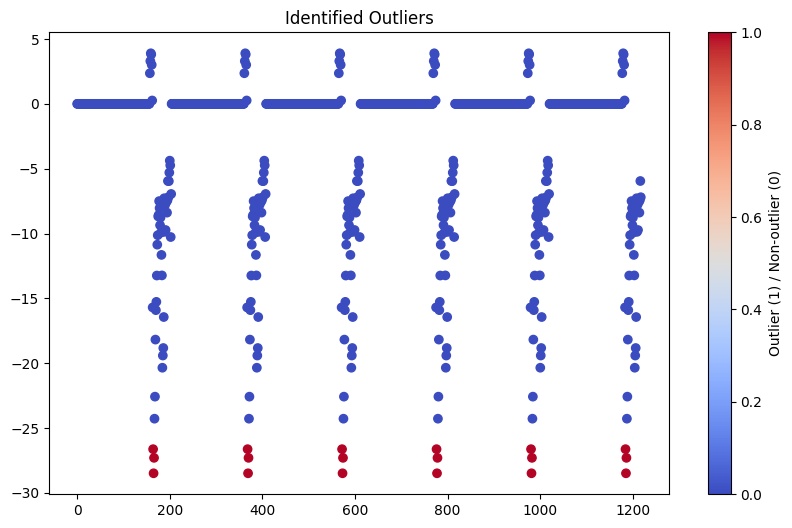

In [86]:
test_df = delete_noise(df, 'Google_Mobility', reduction_method='Statistical')

#### IQR Method

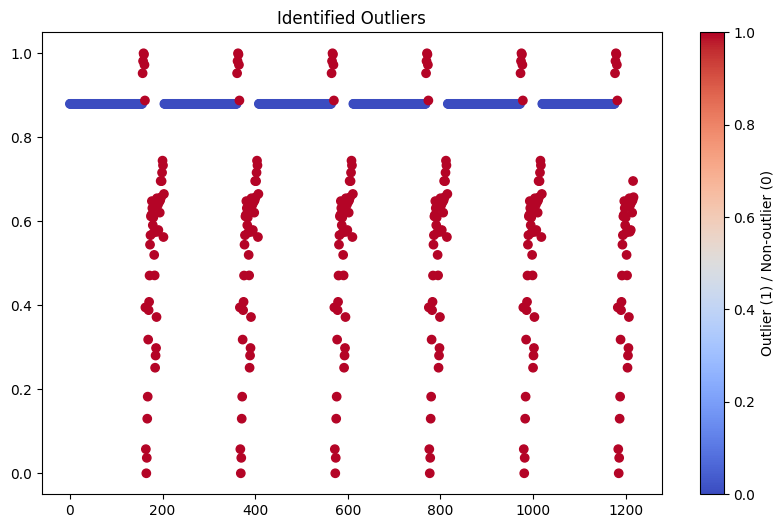

In [99]:
test_df = delete_noise(df, 'Google_Mobility')

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers are actually a pattern and is not greater than 30% decrease prediction (which is lucid in the context of COVID)

### Discount

#### Stadistical Method

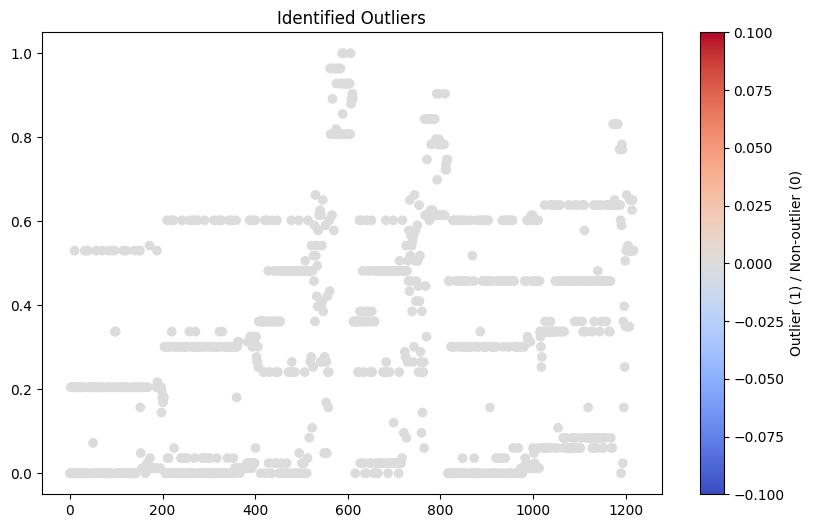

In [101]:
df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
test_df = delete_noise(df, 'Price Discount (%)', reduction_method='Statistical')

#### IQR Method

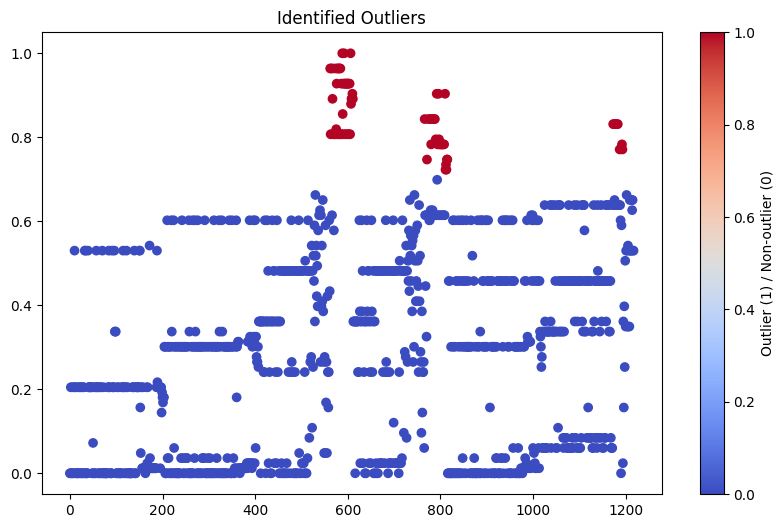

In [102]:
test_df = delete_noise(df, 'Price Discount (%)', error_margin=0.5)

#### Am I deleting outliners?

<font color='red'>**Discarded:**</font> Because the outliers % of discount are  common in the context of this company's timeline given some season and acceptation would only generate weights misplacement later on model training and tuning.

With this, outlier detection is concluded, as there is no binary noise to delete statistically and 'Sales' is the label/target, not a feature.

## Skewed Data

### Google Mobility Normalization

Normalization helps to ensure faster convergence and prevents biased magnitude domination during training.

In [88]:
import plotly.graph_objects as go

def plot(df, column):
  fig = go.Figure()

  fig.add_trace(go.Scatter(y=df[column], mode='lines+markers', name=column))

  # Customize the layout
  fig.update_layout(
      xaxis_title="Index",
      yaxis_title=column,
  )

  # Show the Plotly figure
  fig.show()

plot(df, 'Google_Mobility')

In [89]:
min = df['Google_Mobility'].min()
max = df['Google_Mobility'].max()

df['Google_Mobility'] = (df['Google_Mobility'] - min) / (max - min)

plot(df, 'Google_Mobility')

### Price Discount (%) Normalization

In [94]:
plot(df, 'Price Discount (%)')

In [95]:
min = df['Price Discount (%)'].min()
max = df['Price Discount (%)'].max()

df['Price Discount (%)'] = (df['Price Discount (%)'] - min) / (max - min)

plot(df, 'Price Discount (%)')

## Date Encoding

Encoding 'date' column is necessary so the chosen model can make forecast predictions over seasonality patterns.

In [97]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df.drop(columns=['date'], inplace=True)